In [12]:
import iris
import glob
import iris.plot as iplt
import iris.quickplot as qplt
import datetime as datetime
import iris.coord_categorisation as cat
import sys
import numpy as np
import pandas as pd

In [1]:
# for i in range(0,len(sorted_list)):
#     print(i)
#     ### Load radar data for one day (using IRIS)
#     day_cube = iris.load_cube(sorted_list[i])
#     print(np.nanmax(day_cube.data))

In [4]:


# Get year from input of running the script 
# year = sys.argv[1]
# print (year)
years = [2012]

for year in years:
    print(year)
    ### Get list of files to convert
    radardir = f'/nfs/a161/gy17m2a/PhD/datadir/NIMROD/5mins/OriginalFormat_1km/{year}/'
    file_list=glob.glob(radardir +"*.nc")
    sorted_list = sorted(file_list)
    
    for i in range(0,len(sorted_list)):
        print(i)
        ### Load radar data for one day (using IRIS)
        day_cube = iris.load_cube(sorted_list[i])

        ### Add additional time based variables
        # cat.add_year(day_cube, 'time', name='year')
        # cat.add_month(day_cube, 'time', name='month')
        # cat.add_day_of_month(day_cube, 'time', name='day_of_month')
        cat.add_hour(day_cube, 'time', name='hour')
        # cat.add_day(day_cube, 'time', name='day')

        ### Aggregate to half hourly values (means)
        firsthalfof_hour_constraint = iris.Constraint(time=lambda cell: cell.point.minute <30)
        secondhalfof_hour_constraint = iris.Constraint(time=lambda cell: cell.point.minute >=30)

        # Create empty cube list to populate
        my_cube_list = iris.cube.CubeList()

        # Get list of the hours
        hours = set(day_cube.coord('hour').points)
        
        max_vals = []
        
        # Loop through the hours
        for hour in hours:
            print(hour)

            # Establish constraint to select only this hour
            hour_constraint = iris.Constraint(time=lambda cell: cell.point.hour == hour)
            # Use constraint to select only this hour
            hour_cube = day_cube.extract(hour_constraint)
            # Check the times
            # times = hour_cube.coord('time').points
            # times = [datetime.datetime.fromtimestamp(x ) for x in times]

            # Get only cubes which fall within the first half of the hour and then the second half of the hour
            first_half_of_hour = hour_cube.extract(firsthalfof_hour_constraint)
            second_half_of_hour = hour_cube.extract(secondhalfof_hour_constraint)

            # If there are at least 4 values
            # Find the mean across first/second halves of hour
            # Add to cube list
            if first_half_of_hour == None:
                print("no values in 1st half hour")
            elif len(first_half_of_hour.shape) ==2:
                print("only 1 value in 1st half hour")        
            else:

                if first_half_of_hour.shape[0] >=4:
                    print(f"iter {i}, hour {hour}, first half hour, min value is: {np.nanmin(first_half_of_hour.data)}")
                    print(f"iter {i}, hour {hour}, first half hour, max value is: {np.nanmax(first_half_of_hour.data)}")
                    ## Correct negative 1064 values to np.nan
                    if np.nanmin(first_half_of_hour.data)<0:
                        first_half_of_hour.data = np.where(first_half_of_hour.data <0, np.nan, first_half_of_hour.data)
                        # If somehow still negatives
                        if np.nanmin(first_half_of_hour.data <0):
                            print(first_half_of_hour.data[first_half_of_hour.data<0])
                    # Get rid of this val
                    first_half_of_hour.data = np.where(first_half_of_hour.data ==1023.96875, np.nan, first_half_of_hour.data)  
                    first_half_of_hour.data = np.where(first_half_of_hour.data ==9.969209968386869e+36, np.nan, first_half_of_hour.data)
                    print(f"iter {i}, hour {hour}, first half hour, min value is now: {np.nanmin(first_half_of_hour.data)}") 
                    print(f"iter {i}, hour {hour}, first half hour, max value is now: {np.nanmax(first_half_of_hour.data)}")  
                    
                    # FIND MEAN ACROSS WHOLE FIRST HALF HOUR
                    first_half_hourly_mean = first_half_of_hour.aggregated_by(['hour'],iris.analysis.MEAN)
                    print(np.nanmax(first_half_hourly_mean.data))
                    # first_half_hourly_mean.data.astype('float64')
                    my_cube_list.append(first_half_hourly_mean)
                else:
                    print(f"only {first_half_of_hour.shape[0]} vals in 1st half hour")
 
       

2012
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
8
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
10
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
11
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
15
0
1
2
3
4
5
6
7
8
9
10
11
1

In [6]:
year=2012
### Get list of files to convert
radardir = f'/nfs/a161/gy17m2a/PhD/datadir/NIMROD/5mins/OriginalFormat_1km/{year}/'
file_list=glob.glob(radardir +"*.nc")
sorted_list = sorted(file_list)

In [15]:
day_cube = iris.load_cube(sorted_list[1])
cat.add_hour(day_cube, 'time', name='hour')
numbers, counts = np.unique(day_cube.data.data, return_counts=True)
df=pd.DataFrame({'numbers':numbers, 'counts':counts})
df.sort_values(by='numbers', ascending=False)[:3]

,numbers,counts
4690,9969209968386869046778552952102584320.000,769132051
4689,1023.969,36
4688,1018.750,1


In [ ]:
day_cube = iris.load_cube(sorted_list[2])
cat.add_hour(day_cube, 'time', name='hour')
numbers, counts = np.unique(day_cube.data.data, return_counts=True)
df=pd.DataFrame({'numbers':numbers, 'counts':counts})
df.sort_values(by='numbers', ascending=False)[:3]

In [31]:
# Flatten the data to find the global maximum
max_value = np.max(day_cube.data)
# Find the index of the maximum value
max_index = np.argmax(day_cube.data)

# Convert the flat index to a multidimensional index
max_position = np.unravel_index(max_index, day_cube.shape)
max_position

(21, 708, 877)

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/iris/coord_systems.py:531: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  globe=globe,


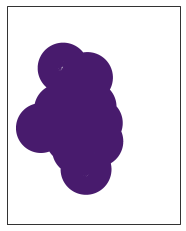

In [25]:
# Assuming the time dimension is the first dimension
time_index = max_position[0]
max_timeslice = day_cube[time_index]
iplt.contourf(max_timeslice)

In [59]:
day_cube = iris.load_cube(sorted_list[2])
# This assumes that the first dimension of the cube is time
time_dimension = 0
contains_max = []

for i, timeslice in enumerate(day_cube.slices_over(time_dimension)):
    # Check if the maximum value is in this timeslice
    if np.any(timeslice.data == max_value):
        contains_max.append((i, True))
    else:
        contains_max.append((i, False))

        # Print which timeslices contain the maximum value
for idx, contains in contains_max:
    if contains:
        print(f"Timeslice at index {idx} contains the maximum value of {max_value}")


Timeslice at index 40 contains the maximum value of 1023.96875
Timeslice at index 49 contains the maximum value of 1023.96875
Timeslice at index 95 contains the maximum value of 1023.96875
Timeslice at index 96 contains the maximum value of 1023.96875
Timeslice at index 105 contains the maximum value of 1023.96875
Timeslice at index 251 contains the maximum value of 1023.96875


In [60]:
def find_max_and_location_in_timeslices(cube):
    results = []
    time_dimension = 0  # Adjust if your time dimension is not the first dimension
    for i, timeslice in enumerate(cube.slices_over(time_dimension)):
        max_value = np.max(timeslice.data)
        position = np.unravel_index(np.argmax(timeslice.data), timeslice.shape)
        latitude = timeslice.coord('projection_y_coordinate').points[position[0]]
        longitude = timeslice.coord('projection_x_coordinate').points[position[1]]
        results.append((i, max_value, latitude, longitude))
    return results

max_values_and_locations = find_max_and_location_in_timeslices(day_cube)

In [54]:
# # List to store timeslices that contain the max value
# max_value_timeslices = []

# # Extract timeslices that contain the max value
# for idx, contains in contains_max:
#     if contains:
#         max_value_timeslices.append(cube[idx])

# # Now max_value_timeslices contains all the timeslices that have the maximum value

In [61]:
import iris
import numpy as np

def find_all_max_locations_in_timeslices(cube):
    """
    Finds the maximum value in each timeslice and returns all its locations.
    
    Args:
        cube (iris.cube.Cube): The Iris cube to analyze.

    Returns:
        list: Each element is a tuple containing the timeslice index, maximum value, 
              and a list of coordinates where the maximum occurs.
    """
    results = []
    time_dimension = 0  # Adjust if your time dimension is not the first dimension
    
    # Iterate over each timeslice
    for i, timeslice in enumerate(cube.slices_over(time_dimension)):
        max_value = np.max(timeslice.data)
        # Find all positions where the timeslice data equals the maximum value
        positions = np.argwhere(timeslice.data == max_value)
        
        # Get the corresponding latitude and longitude for each position
        max_locations = []
        for pos in positions:
            latitude = timeslice.coord('projection_y_coordinate').points[pos[0]]
            longitude = timeslice.coord('projection_x_coordinate').points[pos[1]]
            max_locations.append((latitude, longitude))
        
        # Store the results
        results.append((i, max_value, max_locations))
    
    return results

# Example usage
# cube = iris.load_cube('your_data_file.nc')
# max_values_and_all_locations = find_all_max_locations_in_timeslices(day_cube)
# for result in max_values_and_all_locations:
#     print(f"Timeslice Index: {result[0]}, Max Value: {result[1]}, Locations: {result[2]}")
# # Filter and print the results that match the global maximum value
for entry in max_values_and_locations:
    if entry[1] == global_max_value:
        print(f"Timeslice Index: {entry[0]}, Max Value: {entry[1]}, Location: (Lat: {entry[2]}, Lon: {entry[3]})")


Timeslice Index: 40, Max Value: 1023.96875, Location: (Lat: 83500.0, Lon: 472500.0)
Timeslice Index: 49, Max Value: 1023.96875, Location: (Lat: 83500.0, Lon: 474500.0)
Timeslice Index: 95, Max Value: 1023.96875, Location: (Lat: 800500.0, Lon: 242500.0)
Timeslice Index: 96, Max Value: 1023.96875, Location: (Lat: 711500.0, Lon: 269500.0)
Timeslice Index: 105, Max Value: 1023.96875, Location: (Lat: 386500.0, Lon: 162500.0)
Timeslice Index: 251, Max Value: 1023.96875, Location: (Lat: 95500.0, Lon: 457500.0)


In [62]:
# Example usage
global_max_value = np.max(day_cube.data)

# Filter and print the results that match the global maximum value
for entry in max_values_and_locations:
    if entry[1] == global_max_value:
        print(f"Timeslice Index: {entry[0]}, Max Value: {entry[1]}, Location: (Lat: {entry[2]}, Lon: {entry[3]})")


Timeslice Index: 40, Max Value: 1023.96875, Location: (Lat: 83500.0, Lon: 472500.0)
Timeslice Index: 49, Max Value: 1023.96875, Location: (Lat: 83500.0, Lon: 474500.0)
Timeslice Index: 95, Max Value: 1023.96875, Location: (Lat: 800500.0, Lon: 242500.0)
Timeslice Index: 96, Max Value: 1023.96875, Location: (Lat: 711500.0, Lon: 269500.0)
Timeslice Index: 105, Max Value: 1023.96875, Location: (Lat: 386500.0, Lon: 162500.0)
Timeslice Index: 251, Max Value: 1023.96875, Location: (Lat: 95500.0, Lon: 457500.0)


In [ ]:
for i in range(0,len(sorted_list)):
    print(i)
    ### Load radar data for one day (using IRIS)
    day_cube = iris.load_cube(sorted_list[i])

    ### Add additional time based variables
    # cat.add_year(day_cube, 'time', name='year')
    # cat.add_month(day_cube, 'time', name='month')
    # cat.add_day_of_month(day_cube, 'time', name='day_of_month')
    cat.add_hour(day_cube, 'time', name='hour')
    # cat.add_day(day_cube, 'time', name='day')

    ### Aggregate to half hourly values (means)
    firsthalfof_hour_constraint = iris.Constraint(time=lambda cell: cell.point.minute <30)
    secondhalfof_hour_constraint = iris.Constraint(time=lambda cell: cell.point.minute >=30)

    # Create empty cube list to populate
    my_cube_list = iris.cube.CubeList()

    # Get list of the hours
    hours = set(day_cube.coord('hour').points)

    max_vals = []

    # Loop through the hours
    for hour in hours:
        print(hour)

        # Establish constraint to select only this hour
        hour_constraint = iris.Constraint(time=lambda cell: cell.point.hour == hour)
        # Use constraint to select only this hour
        hour_cube = day_cube.extract(hour_constraint)

In [14]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# numbers, counts = np.unique(first_half_of_hour.data.data, return_counts=True)
df.sort_values(by='numbers', ascending=False)[:30]

,numbers,counts
4690,9969209968386869046778552952102584320.000,769132051
4689,1023.969,36
4688,1018.750,1
4687,1009.969,1
4686,1001.156,1
4685,1000.312,1
4684,997.031,1
4683,995.031,1
4682,993.094,1
4681,945.812,1


In [63]:
for i in range(0,10):
    day_cube = iris.load_cube(sorted_list[i])
    numbers, counts = np.unique(day_cube.data.data, return_counts=True)
    df=pd.DataFrame({'numbers':numbers, 'counts':counts})
    df = df.sort_values(by='numbers', ascending=False)
    print(df[:6])

                                       numbers     counts
1467 9969209968386869046778552952102584320.000  768143373
1466                                  1023.969        222
1465                                  1015.344          1
1464                                  1005.344          1
1463                                  1002.031          1
1462                                   994.344          1
                                       numbers     counts
4690 9969209968386869046778552952102584320.000  769132051
4689                                  1023.969         36
4688                                  1018.750          1
4687                                  1009.969          1
4686                                  1001.156          1
4685                                  1000.312          1
                                       numbers     counts
1719 9969209968386869046778552952102584320.000  770928656
1718                                  1023.969          9
1717          